In [2]:
# Data Processing
import pandas as pd
import numpy as np

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import os

# Over/Undersampling
from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import SMOTE
nr = NearMiss() 
sm = SMOTE()

# Variables
sample_type = 'under'
columns_dropped = ['FSM']
target = 'Residential_CLA'

In [3]:
# Import data
df = pd.read_csv('/workspaces/D2I-Jupyter-Notebook-Tools/ml-data science tutorials/data/CLA_RF_input.csv')
df.head()

,Male?,FSM,SMC,Disabled?,White_British?,Number_contacts,Number_referrals,Number_assessments,Number_strategies,Number_S47s,Number_ICPCs,Number_CIN_plans,Number_CP_plans,CLA,Residential_CLA
0,0,1,0,0,1,0,9,0,1,1,1,3,2,1,0
1,1,1,0,0,1,0,3,0,0,0,0,0,0,0,0
2,1,0,0,0,1,0,4,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0
4,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0


In [4]:
# Set independent and dependent variables
df = df.drop(columns_dropped, axis=1) # Drop any factors that might not be useful
X = df.drop(['CLA','Residential_CLA'], axis=1)
y = df[target] # Target variable
X.head()

,Male?,SMC,Disabled?,White_British?,Number_contacts,Number_referrals,Number_assessments,Number_strategies,Number_S47s,Number_ICPCs,Number_CIN_plans,Number_CP_plans
0,0,0,0,1,0,9,0,1,1,1,3,2
1,1,0,0,1,0,3,0,0,0,0,0,0
2,1,0,0,1,0,4,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,0,0,0,0
4,1,0,1,1,0,1,0,0,0,0,0,0


In [5]:
# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1) # 70% training and 30% test

rf = RandomForestClassifier() # No arguments until we're ready to tune hyperparameters

# Train the classifier on the training data
rf = rf.fit(X_train, y_train)

# Check how well the classifier fits the test data
y_pred = rf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)
print('Balanced accuracy: ', balanced_accuracy)

print("Before Under/Oversampling, counts of CLA: {}".format(sum(y_train == 1))) 
print("Before Under/Oversampling, counts of not CLA: {} \n".format(sum(y_train == 0))) 

Accuracy:  0.9947485452050906
Balanced accuracy:  0.6189765692323146
Before Under/Oversampling, counts of CLA: 865
Before Under/Oversampling, counts of not CLA: 147091 



In [6]:
# Undersample those who are not CLAs OR Oversample those who are CLAs

if sample_type == 'under':
    X_train_samp, y_train_samp = nr.fit_resample(X_train, y_train.ravel())
    print('After Undersampling, the shape of train_X: {}'.format(X_train_samp.shape))
    print('After Undersampling, the shape of train_y: {} \n'.format(y_train_samp.shape))
    print("After Undersampling, counts of label '1': {}".format(sum(y_train_samp == 1)))
    print("After Undersampling, counts of label '0': {}".format(sum(y_train_samp == 0)))

    # Train the classifier on the training data
    rf_sampled = RandomForestClassifier()
    rf_sampled = rf_sampled.fit(X_train_samp, y_train_samp)

    # Check how well the classifier fits the test data
    y_pred = rf_sampled.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)
    print('Balanced accuracy: ', balanced_accuracy)

elif sample_type == 'over':
    X_train_samp, y_train_samp = sm.fit_resample(X_train, y_train) 
    print('After Oversampling, the shape of train_X: {}'.format(X_train_samp.shape))
    print('After Oversampling, the shape of train_y: {} \n'.format(y_train_samp.shape))
    print("After Oversampling, counts of label '1': {}".format(sum(y_train_samp == 1)))
    print("After Oversampling, counts of label '0': {}".format(sum(y_train_samp == 0)))

    # Train the classifier on the training data
    rf_sampled = RandomForestClassifier()
    rf_sampled = rf_sampled.fit(X_train_samp, y_train_samp)

    # Check how well the classifier fits the test data
    y_pred = rf_sampled.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    print('Accuracy: ', accuracy)
    print('Balanced accuracy: ', balanced_accuracy)

/tmp/ipykernel_8473/2414727683.py:4: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_samp, y_train_samp = nr.fit_resample(X_train, y_train.ravel())


After Undersampling, the shape of train_X: (1730, 12)
After Undersampling, the shape of train_y: (1730,) 

After Undersampling, counts of label '1': 865
After Undersampling, counts of label '0': 865
Accuracy:  0.49694847897052563
Balanced accuracy:  0.7166570183925183


In [7]:
for i in range(3):
    tree = rf_sampled.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)


ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

ExecutableNotFound: failed to execute PosixPath('dot'), make sure the Graphviz executables are on your systems' PATH

In [8]:
# Tuning hyperparameters
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf_tuning = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf_tuning, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_samp, y_train_samp)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2032acadd0>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7f2035be1990>})

In [9]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 15, 'n_estimators': 300}


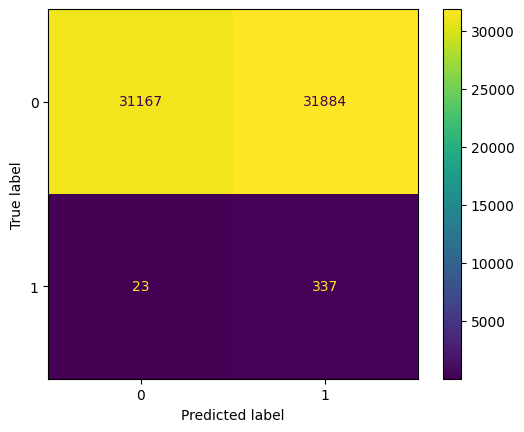

In [10]:
# Generate predictions with the best model
y_pred = best_rf.predict(X_test)

# Create the confusion matrix
cm = confusion_matrix(y_test, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm).plot();

In [11]:
# Display best model
from six import StringIO 
from IPython.display import Image  
import pydotplus

feature_cols = list(X.columns.values)

tree = best_rf.estimators_[1]
dot_data = export_graphviz(tree,
                            feature_names=X_train.columns,  
                            filled=True,  
                            #max_depth=2, 
                            impurity=False, 
                            proportion=True)
graph = graphviz.Source(dot_data)
display(graph)

# dot_data = StringIO()
# export_graphviz(best_rf, out_file=dot_data,  
#                 filled=True, rounded=True,
#                 special_characters=True, feature_names = feature_cols, class_names=['0','1'])
# graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
# graph.write_png('CLA.png')
# Image(graph.create_png())

ModuleNotFoundError: No module named 'pydotplus'

In [ ]:
# Use k-nearest neighbours to look at how important factors we have used in our decision tree are to outcomes

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)

knn.fit(X_train_samp, y_train_samp)
y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Balanced accuracy:", balanced_accuracy)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.8002239359101733
Balanced accuracy: 0.7802017737264728
Precision: 0.13646452351972507
Recall: 0.7584560286510147


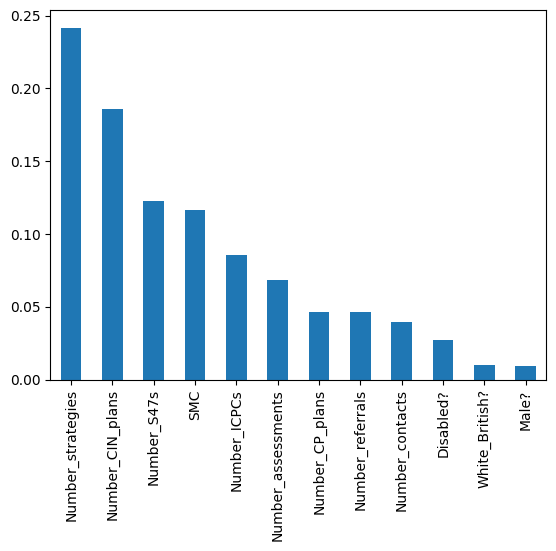

In [ ]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(best_rf.feature_importances_, index=X_train_samp.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();